In [2]:
import os
from termcolor import colored
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

RUN_OPTIONAL_CELLS = True

Mounted at /content/drive


In [3]:
def get_path(path:str):
  '''
  Dynamic Path Finding for cloud and local computing
  '''
  CLOUD_PATH = '/content/drive/MyDrive/Cloud Computing Data/datathon_2022/'
  if IN_COLAB:
    return (CLOUD_PATH+path).replace('//', '/')
  return path
    

In [4]:
train = pd.read_csv(get_path('data/train.csv'))
DROP = ['url', 'user_id']

# Image Data

In [5]:
IMG_SHAPE = (260, 260, 3)
IMG_SOURCE = ['external', 'native'] # native, external, external_2

In [6]:
def to_numpy_arr(file_path:str):
    if file_path.endswith('.csv'):
        data = pd.read_csv(file_path)
        img_arr = None
        for inx, row in tqdm(data.iterrows(), total=len(data)):
            nw_img_path = row['media']
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr
    else:
        img_arr = None
        for current_file in os.listdir(file_path):
            if not current_file.endswith('.jpg'):
                continue
            nw_img_path = os.path.join(file_path, current_file)
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr

## Internal Data

In [7]:
if 'native' in IMG_SOURCE:
    target = pd.read_csv(get_path(f'checkpoints/img_arr_(600, 600, 3)_target.csv'))
    file_name = get_path(f'checkpoints/img_arr_{IMG_SHAPE}')
    if os.path.exists(file_name+'.npy'):
        img_arr = np.load(file_name+'.npy')
    else:
        img_arr = to_numpy_arr(get_path('data/train.csv'))
        np.save(file_name, img_arr)
    
    test_name = get_path(f'checkpoints/test_img_arr_{IMG_SHAPE}')
    if os.path.exists(test_name+'.npy'):
        test_img_arr = np.load(test_name+'.npy')
    else:
        test_img_arr = to_numpy_arr(get_path('data/test.csv'))
        np.save(test_name, test_img_arr)

## External Data

In [8]:
pass
if 'external' in IMG_SOURCE:
    pass

## Image Checking

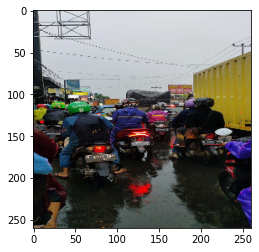

In [9]:
if RUN_OPTIONAL_CELLS:
    import random
    index = random.randint(0, len(img_arr))
    plt.imshow(img_arr[index])

## Image Augmentation

In [10]:
pass

# Modelling

In [11]:
import tensorflow as tf
import keras
from keras import layers, activations, losses, optimizers, initializers, regularizers, metrics, Input, models

## EfficientNetB7

In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(img_arr, target, test_size=0.2, stratify=target)

In [ ]:
from keras.applications import EfficientNetB4
from keras.applications.efficientnet import preprocess_input

input_layer = Input(shape=IMG_SHAPE, dtype=tf.float32)
efficientNetB7_layer = EfficientNetB4()(preprocess_input(input_layer))
efficientNetB7_layer.trainable = False
flatten_layer = layers.Flatten()(efficientNetB7_layer)
dense_layer = layers.Dense(400, activation='relu')(flatten_layer)
dropout_layer = layers.Dropout(.2)(dense_layer)
dense_layer = layers.Dense(200, activation='relu')(flatten_layer)
dropout_layer = layers.Dropout(.2)(dense_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.compile('adam', loss=losses.BinaryCrossentropy(), metrics=['mae', 'acc'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=7, restore_best_weights=True)
hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=64, epochs=20, callbacks=[callback])

In [ ]:
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'validation')
plt.legend()
fig.add_subplot(1, 2, 2)
plt.plot(hist.history['mae'], label = 'train')
plt.plot(hist.history['val_mae'], label = 'validation')
plt.legend()

In [ ]:
model.save(get_path('model2_150neuron.h5'))

# Load Model

In [16]:
test = pd.read_csv(get_path('data/test.csv'))

In [36]:
model = models.load_model(get_path('model.h5'))

In [37]:
pred = model.predict(test_img_arr)

32/32 [==============================] - 5s 116ms/step


In [38]:
output = pd.DataFrame()
output['id'] = test['id']
output['label'] = [int(x>.5) for x in pred]

In [28]:
test.id

0       1213309429254250496
1       1216196702647939072
2       1216296533735309312
3       1234385081482956800
4       1214853229567041537
               ...         
1006    1212371781350084608
1007    1232075152042541056
1008    1213315563595845633
1009    1212970781610663936
1010    1231973813132365825
Name: id, Length: 1011, dtype: int64

In [40]:
output['label'].value_counts()
output.to_csv(get_path('effnetb2_200.csv'), index=False)

In [34]:
output

,id,label
0,1213309429254250496,0
1,1216196702647939072,0
2,1216296533735309312,0
3,1234385081482956800,0
4,1214853229567041537,0
...,...,...
1006,1212371781350084608,0
1007,1232075152042541056,1
1008,1213315563595845633,0
1009,1212970781610663936,0
